### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely areare you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

For starters, let's define a simple MDP from this picture:
<img src='https://s17.postimg.org/mawroys8f/750px-_Markov_Decision_Process_example.png' width=300px>
_img by MistWiz (Own work) [Public domain], via Wikimedia Commons_

In [2]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [3]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [4]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [28]:
import numpy as np
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    #<YOUR CODE>
    #print(state_values)
    a = mdp.get_next_states(state,action)
    #print(a.items)
    i=-1
    X=[]
    
    for key, val in a.items():
        i += 1
        #print(i)
        p = mdp.get_reward(state,action,key)
        q = gamma*state_values[key]
        X.append(val*(p+q))
    #print(X)
    Q = np.sum(X)
    return Q



In [30]:
import numpy as np
test_Vs = {s : i for i, s in enumerate(mdp.get_all_states())}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.allclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

print(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9))
print(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9))

0.6900000000000002
3.9499999999999997


Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [31]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as per formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state): return 0
    a = mdp.get_possible_actions(state)
    print(a)
    b=[]
    
    for x in a:
        b.append(get_action_value(mdp, state_values, state, x, gamma))
        
    v = np.max(b)
    return  v#<YOUR CODE>

In [33]:
test_Vs_vopy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 0.69)
assert test_Vs == test_Vs_vopy, "please do not change state_values in get_new_state_value"

print(get_new_state_value(mdp, test_Vs, 's0', 0.9))
print(get_new_state_value(mdp, test_Vs, 's2', 0.9))

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
1.8
('a0', 'a1')
0.6900000000000002


Finally, let's combine everything we wrote into a working value iteration algo.

In [34]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
min_difference = 0.001 # stop VI if new values are this close to old values (or closer)

# initialize V(s)
state_values = {s : 0 for s in mdp.get_all_states()}


for i in range(num_iter):
    
    # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
    new_state_values = {state : get_new_state_value(mdp, state_values, state, 0.9) for state in mdp.get_all_states()}#<YOUR CODE>
    assert isinstance(new_state_values, dict)
    
    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   "%(i, diff), end="")
    print('   '.join("V(%s) = %.3f"%(s, v) for s,v in state_values.items()), end='\n\n')
    state_values = new_state_values
    
    if diff < min_difference:
        print("Terminated"); break

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    4   |   diff: 0.73024   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    5   |   diff: 0.61135   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    6   |   diff: 0.54664   |   V(s0) = 3.186   V(s1) = 6.275   V(s2) = 3.989

('a0', 'a1')
('a0', 'a1')
('a0', 'a1')
iter    7   |   diff: 0.49198   |   V(s0) = 3.590   V(s1) = 6.790   V(s2) = 4.535

('a0', 'a1')
('a0', 'a1'

In [35]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032)  < 0.01
assert abs(state_values['s1'] - 11.169) < 0.01
assert abs(state_values['s2'] - 8.921)  < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [45]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None
    a = mdp.get_possible_actions(state)
    #print(a)
    b=[]
    
    for x in a:
        b.append(get_action_value(mdp, state_values, state, x, gamma))
        
    c = np.argmax(b)
    q = a[c]
    #print(q)
    #<YOUR CODE>
    return q#<YOUR CODE>

In [46]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a0'

In [47]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)
    
print("average reward: ", np.mean(rewards))

assert(0.85 < np.mean(rewards) < 1.0)

average reward:  0.933


### Frozen lake

In [48]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [49]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {state : get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}
        #<YOUR CODE>
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        
        state_values = new_state_values
        if diff < min_difference:
            print("Terminated"); break
            
    return state_values

In [50]:
state_values = value_iteration(mdp)

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 1.00000   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    1   |   diff: 0.90000   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up'

In [51]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done: break


*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()



after iteration 0
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 1.00000   |   V(start): 0.000 


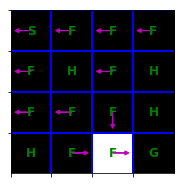

after iteration 1
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.90000   |   V(start): 0.000 


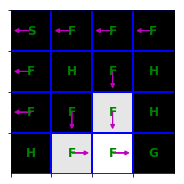

after iteration 2
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.81000   |   V(start): 0.000 


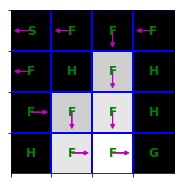

after iteration 3
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.72900   |   V(start): 0.000 


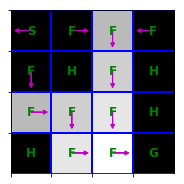

after iteration 4
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.65610   |   V(start): 0.000 


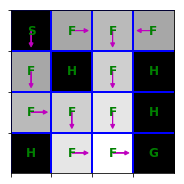

after iteration 5
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.59049   |   V(start): 0.590 


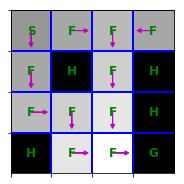

after iteration 6
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


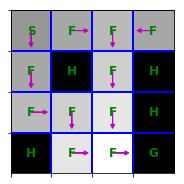

after iteration 7
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


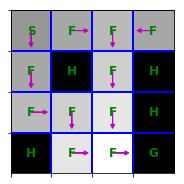

after iteration 8
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


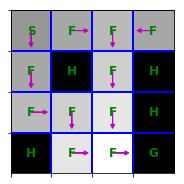

after iteration 9
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


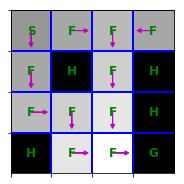

In [53]:
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'rig

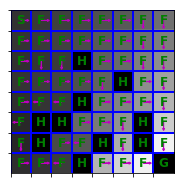

In [54]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [55]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 1.00000   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    1   |   diff: 0.90000   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up'

In [56]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.90000   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    1   |   diff: 0.72900   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up'

In [57]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    0   |   diff: 0.75000   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    1   |   diff: 0.50625   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up'

average reward:  0.667
Well done!


In [58]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left',

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter    6   |   diff: 0.15325   |   V(start): 0.000 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'r

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
iter   14   |   diff: 0.03332   |   V(start): 0.058 
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'r

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left',

('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left', 'down', 'right', 'up')
('left',

### Submit to coursera

In [59]:
from submit import submit_assigment
submit_assigment(
    get_action_value, 
    get_new_state_value, 
    get_optimal_action, 
    value_iteration, 
    'vishnulampo@gmail.com', 
    'ejP6TJymh61hP1FN')